In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt



In [2]:
# Carregar e preparar os dados
data = pd.read_csv('bostonbin.csv')
X = data.iloc[:, :-1].values  # 17 primeiros atributos
y = data.iloc[:, -1].values    # Saída binária

# Divisão inicial dos dados: treino e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [3]:
from sklearn.metrics import f1_score

# Função para Grid Search com validação cruzada e normalização
def perform_grid_search_with_cv(model, params_list, X_train_val, y_train_val, kf):
    best_model = None
    best_params = None
    best_precision_score = -np.inf
    
    for train_index, val_index in kf.split(X_train_val):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        # Normalização dos dados de treino e validação
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        # Grid Search Manual
        for params in params_list:
            model.set_params(**params)
            model.fit(X_train_fold_scaled, y_train_fold)
            y_pred = model.predict(X_val_fold_scaled)
            
            
            score = precision_score(y_val_fold, y_pred)
            
            # Atualizar os melhores parâmetros
            if score > best_precision_score:
                best_precision_score = score
                best_params = params
                best_model = model
    
    return best_model, best_params, best_precision_score


In [4]:

# Definindo o objeto KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definindo parâmetros para SVM
svm_params = [
    {'C': c, 'gamma': g}
    for c in [2**i for i in range(-5, 16, 2)]
    for g in [2**i for i in range(-15, 4, 2)]
]

# Grid Search para SVM
svm = SVC(kernel='rbf')
best_svm, best_svm_params, best_precision_scoresvm = perform_grid_search_with_cv(svm, svm_params, X_train_val, y_train_val, kf)

print(f"Melhores parâmetros para SVM: {best_svm_params}")
print(f"Melhor precisão para SVM: {best_precision_scoresvm}")

# Definindo parâmetros para Árvore de Decisão
tree_params = [
    {'max_depth': d, 'min_samples_leaf': m}
    for d in range(1, 11)
    for m in range(1, 6)
]

# Grid Search para Árvore de Decisão
tree = DecisionTreeClassifier(criterion='gini')
best_tree, best_tree_params, best_precision_score_tree = perform_grid_search_with_cv(tree, tree_params, X_train_val, y_train_val, kf)

print(f"Melhores parâmetros para Árvore de Decisão: {best_tree_params}")
print(f"Melhor precisão para Árvore de Decisão: {best_precision_score_tree}")


Melhores parâmetros para SVM: {'C': 8192, 'gamma': 0.001953125}
Melhor precisão para SVM: 1.0
Melhores parâmetros para Árvore de Decisão: {'max_depth': 5, 'min_samples_leaf': 1}
Melhor precisão para Árvore de Decisão: 1.0


In [5]:
# Normalização final do conjunto de teste
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# Treinamento final com o melhor modelo SVM
best_svm.fit(X_train_val_scaled, y_train_val)

# Treinamento final com o melhor modelo Árvore de Decisão
best_tree.fit(X_train_val_scaled, y_train_val)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

In [11]:
# Avaliação final dos modelos
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_scores = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:, 1]

    print(f"Desempenho do {model.__class__.__name__}:")
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
    print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}\n")

    # Curvas ROC e Precision-Recall
    def plot_curves(y_true, y_scores, model_name):
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive')
        plt.ylabel('True Positive')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        plt.figure()
        plt.plot(recall, precision, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Curva Precision-Recall - {model_name}')
        plt.legend(loc="lower left")
        plt.show()

    plot_curves(y_test, y_scores, model.__class__.__name__)



Desempenho do SVC:
Acurácia: 0.6645
Precisão: 0.6212
Revocação: 0.9880
F1-Score: 0.7628



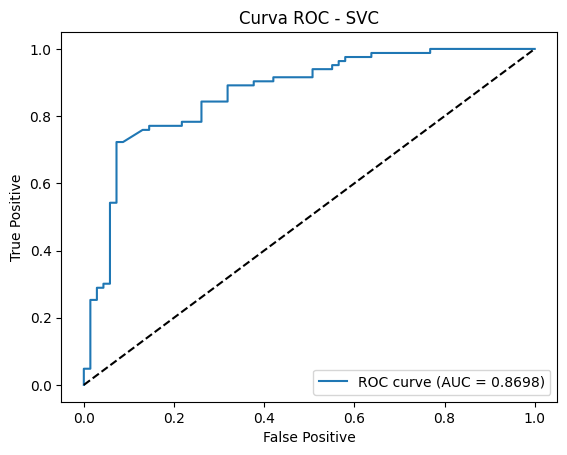

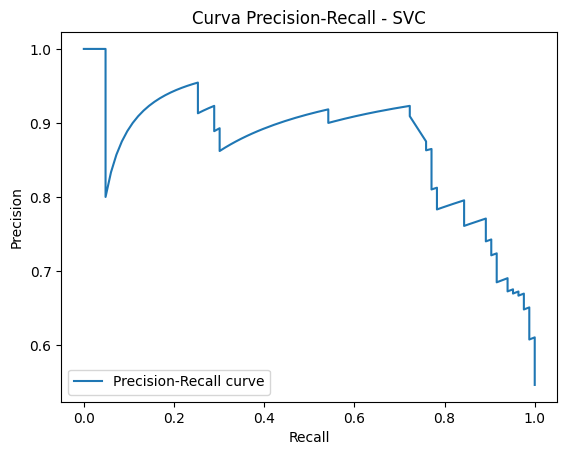

In [12]:
evaluate_model(best_svm, X_test_scaled, y_test)


Desempenho do DecisionTreeClassifier:
Acurácia: 0.8684
Precisão: 0.9091
Revocação: 0.8434
F1-Score: 0.8750



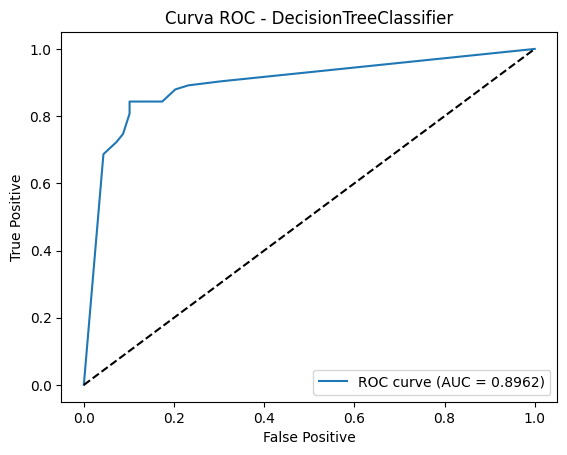

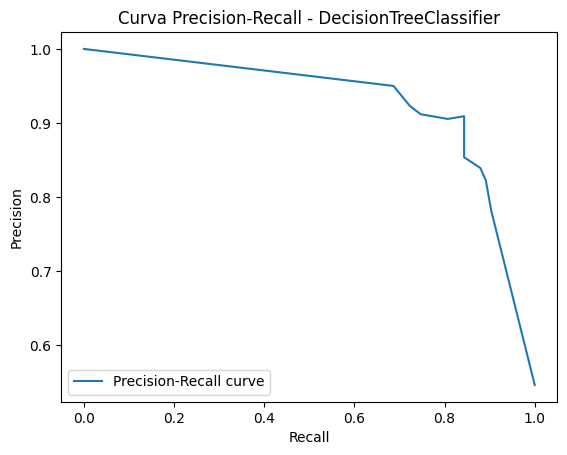

In [8]:
evaluate_model(best_tree, X_test_scaled, y_test)